In [71]:
import numpy as np
import pandas as pd
import pickle
# from autofeat import AutoFeatRegressor
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

In [72]:
cs2_odds_df = pd.read_pickle("dataframes/polished_mainframe.pkl")
cs2_odds_df = cs2_odds_df.astype(float)

# # remove outliers
# cs2_odds_df = cs2_odds_df[np.abs(stats.zscore(cs2_odds_df['total_kills'])) < 3]

# split off results before normalization
cs2_odds_df_results = cs2_odds_df['total_kills']

# Split results between training, dev, and test
cs2_odds_df_training_results = cs2_odds_df_results.head((len(cs2_odds_df.index) * 7) // 10)
cs2_odds_df_dev_results = cs2_odds_df_results.iloc[((len(cs2_odds_df.index) * 7) // 10):((len(cs2_odds_df.index) * 9) // 10) - 1]
cs2_odds_df_test_results = cs2_odds_df_results.tail((len(cs2_odds_df.index) * 1) // 10)

# Full list of columns in order of importance
columns_ranked = [
    "rating", "odds", "rounds_with_a_kill", "opponent_avg_rounds_won_in_losses",
    "avg_rounds_lost_in_wins", "opponent_avg_rounds_lost_in_wins", "avg_rounds_won_in_losses",
    "damage_per_round", "damage_per_round_win", "win_percentage_after_opening_kill",
    "assisted_kills_percentage", "one_on_one_win_percentage", "last_alive_percentage",
    "opening_kills_per_round", "damage_per_kill", "opening_success", "support_attacks_per_round",
    "trade_kills_percentage", "support_rounds", "opening_deaths_traded_percentage",
    "opponent_rank", "team_rank", "rounds_with_a_multikill", "assists_per_round",
    "traded_deaths_percentage", "clutch_points_per_round", "kills_per_round_win",
    "opening_deaths_per_round", "opening_attempts", "trade_kills_per_round",
    "saved_teammate_per_round", "saved_by_teammate_per_round", "kills_per_round",
    "traded_deaths_per_round"
]

# Select only the top 15
top_15_columns = columns_ranked[:15]

# Assume df is your original DataFrame
cs2_odds_df = cs2_odds_df[top_15_columns]

In [80]:
# Normalize data before spltting off
cs2_odds_df=(cs2_odds_df-cs2_odds_df.min())/(cs2_odds_df.max()-cs2_odds_df.min())

# Split data between training, dev, and test
cs2_odds_df_training = cs2_odds_df.head((len(cs2_odds_df.index) * 7) // 10)
cs2_odds_df_dev = cs2_odds_df.iloc[((len(cs2_odds_df.index) * 7) // 10):((len(cs2_odds_df.index) * 9) // 10) - 1]
cs2_odds_df_test = cs2_odds_df.tail((len(cs2_odds_df.index) * 1) // 10)

       rating      odds  rounds_with_a_kill  \
215  0.506667  0.335603            0.595918   
140  0.480000  0.054475            0.546939   
182  0.613333  0.105058            0.751020   
66   0.386667  0.058366            0.383673   
43   0.426667  0.000000            0.583673   
..        ...       ...                 ...   
66   0.453333  0.873541            0.506122   
128  0.546667  0.309339            0.632653   
58   0.346667  0.523346            0.489796   
13   0.666667  0.008755            0.689796   
93   0.466667  0.338521            0.604082   

     opponent_avg_rounds_won_in_losses  avg_rounds_lost_in_wins  \
215                           0.666667                 0.675359   
140                           0.862416                 0.438070   
182                           0.615213                 0.543677   
66                            0.638702                 0.658409   
43                            0.373602                 0.556714   
..                               

In [74]:
# Split off results
cs2_odds_df_training_results = cs2_odds_df_training_results.values.ravel()
cs2_odds_df_dev_results = cs2_odds_df_dev_results.values.ravel()
cs2_odds_df_test_results = cs2_odds_df_test_results.values.ravel()

In [75]:
# dev set experimentation 
mlp_reg = MLPRegressor(max_iter=2000, ).fit(cs2_odds_df_training, cs2_odds_df_training_results)
score = mlp_reg.score(cs2_odds_df_dev, cs2_odds_df_dev_results)
print(f'MLP Regressor dev Score: {score}')
y_predicted = mlp_reg.predict(cs2_odds_df_dev)
rmse = np.sqrt(mean_squared_error(cs2_odds_df_dev_results, y_predicted))
print(f'MLP Regressor dev RMSE: {rmse}')

MLP Regressor dev Score: 0.0785258398080586
MLP Regressor dev RMSE: 8.067797803858099


In [36]:
from sklearn.model_selection import GridSearchCV
from itertools import product

mlpr = MLPRegressor(max_iter=2000)
first_layer_neurons = np.arange(100,110,10)
second_layer_neurons = np.arange(20, 100, 20)
hidden_layer_sizes = list(product(first_layer_neurons, second_layer_neurons))
param_list = {"hidden_layer_sizes": hidden_layer_sizes,
              "activation": ["identity", "logistic", "tanh", "relu"], 
              "solver": ["lbfgs", "adam"], 
              "alpha": [0.00005,0.0005]}
grid_search = GridSearchCV(estimator=mlpr, 
                      param_grid=param_list,
                      cv = 3, 
                      verbose=2,
                      n_jobs = -1)
grid_search.fit(cs2_odds_df_training, cs2_odds_df_training_results)
print(grid_search.best_estimator_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
MLPRegressor(activation='tanh', alpha=5e-05,
             hidden_layer_sizes=(np.int64(100), np.int64(40)), max_iter=2000)


In [76]:
# dev set experimentation 
mlp_reg = MLPRegressor(activation='tanh', 
                       alpha=5e-04,
                       hidden_layer_sizes=(np.int64(100), np.int64(40)), 
                       max_iter=2000).fit(cs2_odds_df_training, cs2_odds_df_training_results)
score = mlp_reg.score(cs2_odds_df_dev, cs2_odds_df_dev_results)
print(f'MLP Regressor dev Score: {score}')
y_predicted = mlp_reg.predict(cs2_odds_df_dev)
rmse = np.sqrt(mean_squared_error(cs2_odds_df_dev_results, y_predicted))
print(f'MLP Regressor dev RMSE: {rmse}')

MLP Regressor dev Score: 0.09977787272348215
MLP Regressor dev RMSE: 7.974220978218061


In [77]:
# test set results
reg = MLPRegressor(activation='tanh', 
                   alpha=5e-04,
                   hidden_layer_sizes=(np.int64(100), np.int64(40)), 
                   max_iter=2000)
score = mlp_reg.score(cs2_odds_df_test, cs2_odds_df_test_results)
print(f'MLP Regressor test Score: {score}')
y_predicted = mlp_reg.predict(cs2_odds_df_test)
rmse = np.sqrt(mean_squared_error(cs2_odds_df_test_results, y_predicted))
print(f'MLP Regressor test RMSE: {rmse}')

MLP Regressor test Score: 0.11069221127477136
MLP Regressor test RMSE: 8.062662823748608


In [78]:
less_than_3_diff_count = 0
total_count = 0
for i in range(len(y_predicted)):
    if abs(y_predicted[i] - cs2_odds_df_dev_results[i]) < 3:
        less_than_3_diff_count += 1
    total_count+=1
print(less_than_3_diff_count)
print(less_than_3_diff_count / total_count)

79
0.2633333333333333


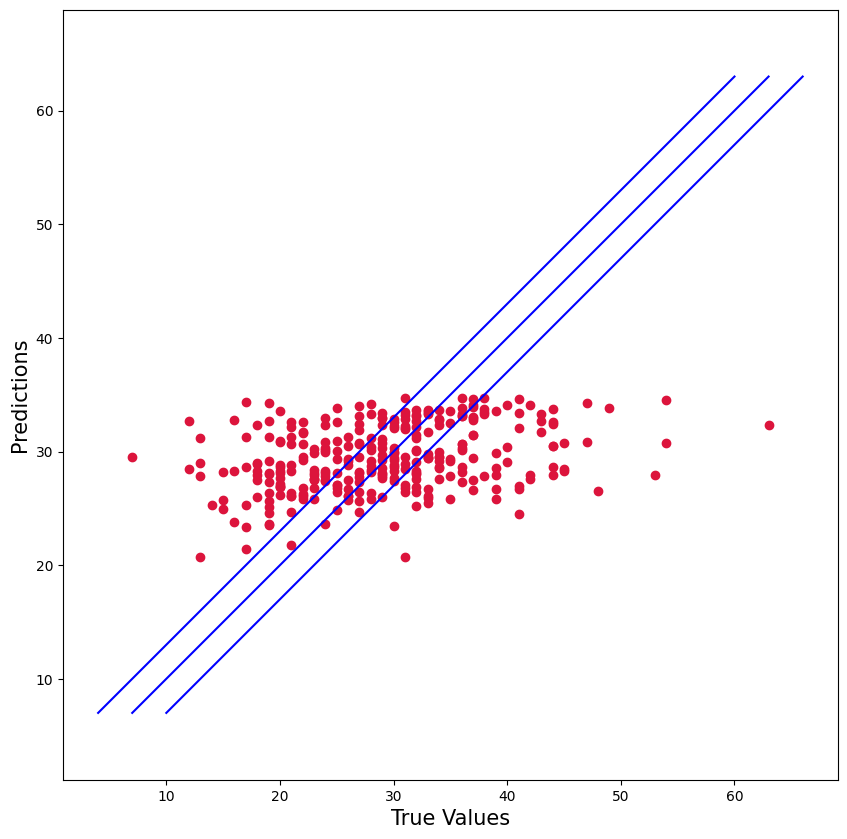

In [79]:
plt.figure(figsize=(10,10))
plt.scatter(cs2_odds_df_test_results, y_predicted, c='crimson')
p1 = max(max(y_predicted), max(cs2_odds_df_test_results))
p2 = min(min(y_predicted), min(cs2_odds_df_test_results))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.plot([p1+3, p2+3], [p1, p2], 'b-')
plt.plot([p1-3, p2-3], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()